# Gaming QoE Paper Reproduction

This notebook reproduces the main experiments reported in the Gaming Quality of Experience research paper. It assumes preprocessed CSV datasets are available and runs end-to-end experiments to generate all paper figures and tables.

**Expected outputs:**
- Main 3-class classification results for 5 models on 10-second windows
- Window size sensitivity analysis for XGBoost (3s, 5s, 10s, 15s)
- Confusion matrices and consolidated metrics tables
- Reproducibility artifacts with version information

## Environment & Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import sys
import json
from datetime import datetime

# Machine learning imports
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

# Import existing repo utilities
from model_utils import make_models, plot_cm
from rank import rank_str_to_int_mapping_3_classes, rank_qoe_3_classes

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set matplotlib parameters for high-quality plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("Environment setup complete!")
print(f"Python version: {sys.version}")

Environment setup complete!
Python version: 3.11.13 (main, Aug 11 2025, 09:41:40) [GCC 13.3.0]


## Global Configuration

In [2]:
# =============================================================================
# CONFIGURATION - MODIFY THESE PATHS IF NEEDED
# =============================================================================

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Data paths
DATA_DIR = Path("output")
DATA_FILE_10S = DATA_DIR / "window_10_1754904064.csv"
DATA_FILE_TEMPLATE = "window_{window}s_dataset.csv"

# Artifacts directory
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
TABLES_DIR = ARTIFACTS_DIR / "tables"

# Ensure directories exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Target and feature configuration
TARGET_COLUMN = "y_qoe_by_ping"  # 3-class ping-based QoE (primary target)
SURVEY_TARGET_COLUMN = "self_rate_qoe_score"  # Survey-based QoE for comparison
N_CLASSES = 3  # Default: 3-class classification (set to 2 for binary)

# Feature columns (from existing codebase)
FEATURE_COLUMNS = [
    'src2dst_avg_pkt_size', 'src2dst_avg_pkt_size_mean', 'src2dst_avg_pkt_size_median', 
    'src2dst_avg_pkt_size_std', 'src2dst_avg_pkt_size_min', 'src2dst_avg_pkt_size_max',
    'src2dst_pps', 'src2dst_pps_mean', 'src2dst_pps_median', 
    'src2dst_pps_std', 'src2dst_pps_min', 'src2dst_pps_max',
    'dst2src_avg_pkt_size', 'dst2src_avg_pkt_size_mean', 'dst2src_avg_pkt_size_median', 
    'dst2src_avg_pkt_size_std', 'dst2src_avg_pkt_size_min', 'dst2src_avg_pkt_size_max',
    'dst2src_pps', 'dst2src_pps_mean', 'dst2src_pps_median', 
    'dst2src_pps_std', 'dst2src_pps_min', 'dst2src_pps_max',
    'pkt_dir_ratio', 'pkt_dir_ratio_mean', 'pkt_dir_ratio_median', 
    'pkt_dir_ratio_std', 'pkt_dir_ratio_min', 'pkt_dir_ratio_max'
]

# Train/test split configuration
TEST_SIZE = 0.2
STRATIFY = True

# Window sizes for sensitivity analysis
WINDOW_SIZES = [3, 5, 10, 15]
WINDOW_FILE_MAPPING = {
    3: DATA_DIR / "window_3_1756030271.csv",
    5: DATA_DIR / "window_5_1756032959.csv", 
    10: DATA_DIR / "window_10_1754904064.csv",
    15: DATA_DIR / "window_15_1756035248.csv"
}

# Model hyperparameters (matching repo defaults)
MODEL_PARAMS = {
    'DT': {'random_state': RANDOM_STATE},
    'LR': {'max_iter': 1000, 'random_state': RANDOM_STATE},
    'RF': {'n_estimators': 200, 'random_state': RANDOM_STATE},
    'SVM': {'kernel': 'rbf', 'random_state': RANDOM_STATE},
    'XGBoost': {
        'objective': 'multi:softprob',
        'num_class': N_CLASSES,
        'n_estimators': 300,
        'learning_rate': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE
    }
}

print(f"Configuration loaded!")
print(f"Target: {TARGET_COLUMN} ({N_CLASSES} classes)")
print(f"Features: {len(FEATURE_COLUMNS)} network traffic features")
print(f"Window sizes for analysis: {WINDOW_SIZES}")
print(f"Artifacts will be saved to: {ARTIFACTS_DIR}")

Configuration loaded!
Target: y_qoe_by_ping (3 classes)
Features: 30 network traffic features
Window sizes for analysis: [3, 5, 10, 15]
Artifacts will be saved to: artifacts


## Data Loading and Preprocessing

In [3]:
def load_dataset(filepath, target_col=TARGET_COLUMN, feature_cols=None, validate_classes=True):
    """
    Load and preprocess dataset from CSV file.
    
    Args:
        filepath: Path to CSV file
        target_col: Name of target column
        feature_cols: List of feature columns (if None, uses FEATURE_COLUMNS)
        validate_classes: Whether to check for expected number of classes
    
    Returns:
        tuple: (X, y, dataset) where X=features, y=target, dataset=full dataframe
    """
    print(f"Loading dataset from: {filepath}")
    
    if not Path(filepath).exists():
        raise FileNotFoundError(f"Dataset file not found: {filepath}")
    
    # Load dataset
    dataset = pd.read_csv(filepath)
    print(f"Loaded {dataset.shape[0]} samples with {dataset.shape[1]} columns")
    
    # Use default features if not specified
    if feature_cols is None:
        feature_cols = FEATURE_COLUMNS
    
    # Check if we need to generate QoE labels from ping
    if target_col == "y_qoe_by_ping" and target_col not in dataset.columns:
        if 'ping' in dataset.columns:
            print("Generating 3-class ping-based QoE labels...")
            dataset[target_col] = dataset['ping'].apply(
                lambda ping: rank_str_to_int_mapping_3_classes[rank_qoe_3_classes(ping)]
            )
        else:
            raise ValueError(f"Cannot generate {target_col}: 'ping' column not found")
    
    # Check if we need to transform survey QoE to 3 classes
    if target_col == "self_rate_qoe_score" and N_CLASSES == 3:
        print("Converting survey QoE to 3 classes: [1,2]→1, [3]→2, [4,5]→3")
        dataset[target_col] = dataset[target_col].apply(
            lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3)
        )
    
    # Remove rows with missing feature values
    initial_size = len(dataset)
    dataset = dataset.dropna(subset=feature_cols + [target_col])
    final_size = len(dataset)
    
    if final_size < initial_size:
        print(f"Dropped {initial_size - final_size} rows with missing values")
    
    # Extract features and target
    X = dataset[feature_cols]
    y = dataset[target_col]
    
    # Print class distribution
    class_counts = y.value_counts().sort_index()
    print(f"\nClass distribution for {target_col}:")
    for cls, count in class_counts.items():
        print(f"  Class {cls}: {count:,} samples ({count/len(y)*100:.1f}%)")
    
    # Validate number of classes
    if validate_classes and len(class_counts) != N_CLASSES:
        print(f"WARNING: Expected {N_CLASSES} classes, found {len(class_counts)}")
    
    print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
    return X, y, dataset

# Load the main 10-second dataset
print("=" * 50)
print("LOADING MAIN DATASET (10-second windows)")
print("=" * 50)

X_main, y_main, dataset_main = load_dataset(DATA_FILE_10S, TARGET_COLUMN)

LOADING MAIN DATASET (10-second windows)
Loading dataset from: output/window_10_1754904064.csv
Loaded 33520 samples with 41 columns
Generating 3-class ping-based QoE labels...
Dropped 1355 rows with missing values

Class distribution for y_qoe_by_ping:
  Class 1: 13,785 samples (42.9%)
  Class 2: 9,652 samples (30.0%)
  Class 3: 8,728 samples (27.1%)
Final dataset: 32165 samples, 30 features


## Train/Test Split

In [7]:
def create_stratified_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """
    Create stratified train/test split consistent with the original codebase.
    Uses experiment ID-based splitting if available, otherwise random stratified split.
    """
    print(f"Creating stratified split (test_size={test_size}, random_state={random_state})")
    
    # Encode labels to 0-based indexing for compatibility with sklearn models
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
    
    # Check if we can use experiment-based splitting (from original codebase)
    if 'exp_id' in dataset_main.columns:
        print("Using experiment-based split: every 4th experiment for testing")
        train_mask = dataset_main['exp_id'] % 4 != 0
        test_mask = dataset_main['exp_id'] % 4 == 0
        
        X_train = X[train_mask]
        X_test = X[test_mask]
        y_train = y_encoded[train_mask]
        y_test = y_encoded[test_mask]
    else:
        print("Using random stratified split")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=random_state, 
            stratify=y_encoded if STRATIFY else None
        )
    
    print(f"\nSplit results:")
    print(f"  Training: {X_train.shape[0]:,} samples")
    print(f"  Testing:  {X_test.shape[0]:,} samples")
    print(f"  Total:    {X_train.shape[0] + X_test.shape[0]:,} samples")
    
    # Check class distribution in splits
    train_dist = pd.Series(y_train).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()
    
    print(f"\nClass distribution (encoded):")
    print(f"{'Class':<8} {'Train':<10} {'Train%':<8} {'Test':<10} {'Test%':<8}")
    print("-" * 50)
    for cls in sorted(np.unique(y_encoded)):
        train_count = train_dist.get(cls, 0)
        test_count = test_dist.get(cls, 0)
        train_pct = train_count / len(y_train) * 100
        test_pct = test_count / len(y_test) * 100
        print(f"{cls:<8} {train_count:<10,} {train_pct:<8.1f} {test_count:<10,} {test_pct:<8.1f}")
    
    return X_train, X_test, y_train, y_test, label_encoder

# Create the split
X_train, X_test, y_train, y_test, label_encoder = create_stratified_split(X_main, y_main)

Creating stratified split (test_size=0.2, random_state=42)
Label encoding: {1: 0, 2: 1, 3: 2}
Using experiment-based split: every 4th experiment for testing

Split results:
  Training: 23,742 samples
  Testing:  8,423 samples
  Total:    32,165 samples

Class distribution (encoded):
Class    Train      Train%   Test       Test%   
--------------------------------------------------
0        10,028     42.2     3,757      44.6    
1        7,187      30.3     2,465      29.3    
2        6,527      27.5     2,201      26.1    


## Model Setup

In [8]:
def create_model_pipelines(n_classes=N_CLASSES):
    """
    Create model instances with preprocessing pipelines where needed.
    Uses existing model_utils.make_models() function and adds preprocessing.
    """
    print(f"Creating models for {n_classes}-class classification")
    
    # Get base models from existing utility
    base_models = make_models(n_classes)
    
    # Create pipelines with preprocessing where needed
    models = {}
    
    for name, model in base_models:
        if name in ['LR', 'SVM']:  # Models that benefit from scaling
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
            models[name] = pipeline
        else:  # Tree-based models: RF, DT, XGBoost
            models[name] = model
    
    print(f"Created {len(models)} models: {list(models.keys())}")
    return models

# Create models
models = create_model_pipelines(N_CLASSES)

Creating models for 3-class classification
Created 5 models: ['RF', 'DT', 'LR', 'SVM', 'XGBoost']


## Main Experiment: 3-Class Classification on 10-Second Windows

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a single model, returning detailed metrics.
    """
    print(f"\nTraining {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    
    # Macro and weighted averages
    macro_f1 = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
    weighted_f1 = precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro F1: {macro_f1:.4f}")
    print(f"  Weighted F1: {weighted_f1:.4f}")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'per_class_support': support,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

def save_confusion_matrix(cm, y_true, y_pred, model_name, save_path, label_encoder):
    """
    Save confusion matrix plot using the existing plot_cm function.
    """
    # Convert encoded labels back to original for display
    y_true_original = label_encoder.inverse_transform(y_true)
    y_pred_original = label_encoder.inverse_transform(y_pred)
    class_labels = sorted(label_encoder.classes_)
    
    # Use existing utility function
    plot_cm(
        y_true_original, y_pred_original, 
        labels=class_labels,
        title=f"Confusion Matrix - {model_name} (3-Class QoE)",
        show_plot=False,
        save_path=save_path
    )
    print(f"  Saved confusion matrix: {save_path}")

# Main experiment loop
print("=" * 60)
print("MAIN EXPERIMENT: 3-CLASS QoE CLASSIFICATION (10-SECOND WINDOWS)")
print("=" * 60)

results = []
detailed_results = {}

for model_name, model in models.items():
    # Evaluate model
    result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    detailed_results[model_name] = result
    
    # Save confusion matrix
    cm_path = FIGURES_DIR / f"confusion_matrix_{model_name}.png"
    save_confusion_matrix(
        result['confusion_matrix'], y_test, result['y_pred'], 
        model_name, cm_path, label_encoder
    )
    
    # Collect results for table
    for class_idx in range(N_CLASSES):
        # Map back to original class labels for display
        original_class = label_encoder.classes_[class_idx]
        results.append({
            'model': model_name,
            'class': original_class,
            'precision': result['per_class_precision'][class_idx],
            'recall': result['per_class_recall'][class_idx],
            'f1': result['per_class_f1'][class_idx],
            'support': result['per_class_support'][class_idx],
            'accuracy': result['accuracy'],
            'macro_f1': result['macro_f1'],
            'weighted_f1': result['weighted_f1']
        })
    
    # Add aggregate rows
    results.append({
        'model': model_name,
        'class': 'macro_avg',
        'precision': np.mean(result['per_class_precision']),
        'recall': np.mean(result['per_class_recall']),
        'f1': result['macro_f1'],
        'support': np.sum(result['per_class_support']),
        'accuracy': result['accuracy'],
        'macro_f1': result['macro_f1'],
        'weighted_f1': result['weighted_f1']
    })
    
    results.append({
        'model': model_name,
        'class': 'weighted_avg',
        'precision': np.average(result['per_class_precision'], weights=result['per_class_support']),
        'recall': np.average(result['per_class_recall'], weights=result['per_class_support']),
        'f1': result['weighted_f1'],
        'support': np.sum(result['per_class_support']),
        'accuracy': result['accuracy'],
        'macro_f1': result['macro_f1'],
        'weighted_f1': result['weighted_f1']
    })
    
    results.append({
        'model': model_name,
        'class': 'overall',
        'precision': result['accuracy'],  # Overall accuracy
        'recall': result['accuracy'],
        'f1': result['accuracy'],
        'support': np.sum(result['per_class_support']),
        'accuracy': result['accuracy'],
        'macro_f1': result['macro_f1'],
        'weighted_f1': result['weighted_f1']
    })

print(f"\nCompleted evaluation of {len(models)} models")
print(f"Confusion matrices saved to: {FIGURES_DIR}")

MAIN EXPERIMENT: 3-CLASS QoE CLASSIFICATION (10-SECOND WINDOWS)

Training RF...
  Accuracy: 0.8222
  Macro F1: 0.8137
  Weighted F1: 0.8154
  Accuracy: 0.8222
  Macro F1: 0.8137
  Weighted F1: 0.8154
  Saved confusion matrix: artifacts/figures/confusion_matrix_RF.png

Training DT...
  Saved confusion matrix: artifacts/figures/confusion_matrix_RF.png

Training DT...
  Accuracy: 0.7447
  Macro F1: 0.7417
  Weighted F1: 0.7406
  Accuracy: 0.7447
  Macro F1: 0.7417
  Weighted F1: 0.7406
  Saved confusion matrix: artifacts/figures/confusion_matrix_DT.png

Training LR...
  Saved confusion matrix: artifacts/figures/confusion_matrix_DT.png

Training LR...
  Accuracy: 0.7719
  Macro F1: 0.7536
  Weighted F1: 0.7565
  Accuracy: 0.7719
  Macro F1: 0.7536
  Weighted F1: 0.7565
  Saved confusion matrix: artifacts/figures/confusion_matrix_LR.png

Training SVM...
  Saved confusion matrix: artifacts/figures/confusion_matrix_LR.png

Training SVM...
  Accuracy: 0.8246
  Macro F1: 0.8104
  Weighted F1: 0

## Window Size Sensitivity Analysis (XGBoost)

WINDOW SIZE SENSITIVITY ANALYSIS (XGBoost)

--- Processing 3-second windows ---
Loading dataset from: output/window_3_1756030271.csv
Loaded 33520 samples with 41 columns
Generating 3-class ping-based QoE labels...
Dropped 434 rows with missing values

Class distribution for y_qoe_by_ping:
  Class 1: 14,241 samples (43.0%)
  Class 2: 9,906 samples (29.9%)
  Class 3: 8,939 samples (27.0%)
Final dataset: 33086 samples, 30 features
Using experiment-based split (consistent with main experiment)
Split: 24,454 train, 8,632 test
Creating models for 3-class classification
Created 5 models: ['RF', 'DT', 'LR', 'SVM', 'XGBoost']

Training XGBoost-3s...
Dropped 434 rows with missing values

Class distribution for y_qoe_by_ping:
  Class 1: 14,241 samples (43.0%)
  Class 2: 9,906 samples (29.9%)
  Class 3: 8,939 samples (27.0%)
Final dataset: 33086 samples, 30 features
Using experiment-based split (consistent with main experiment)
Split: 24,454 train, 8,632 test
Creating models for 3-class classifica

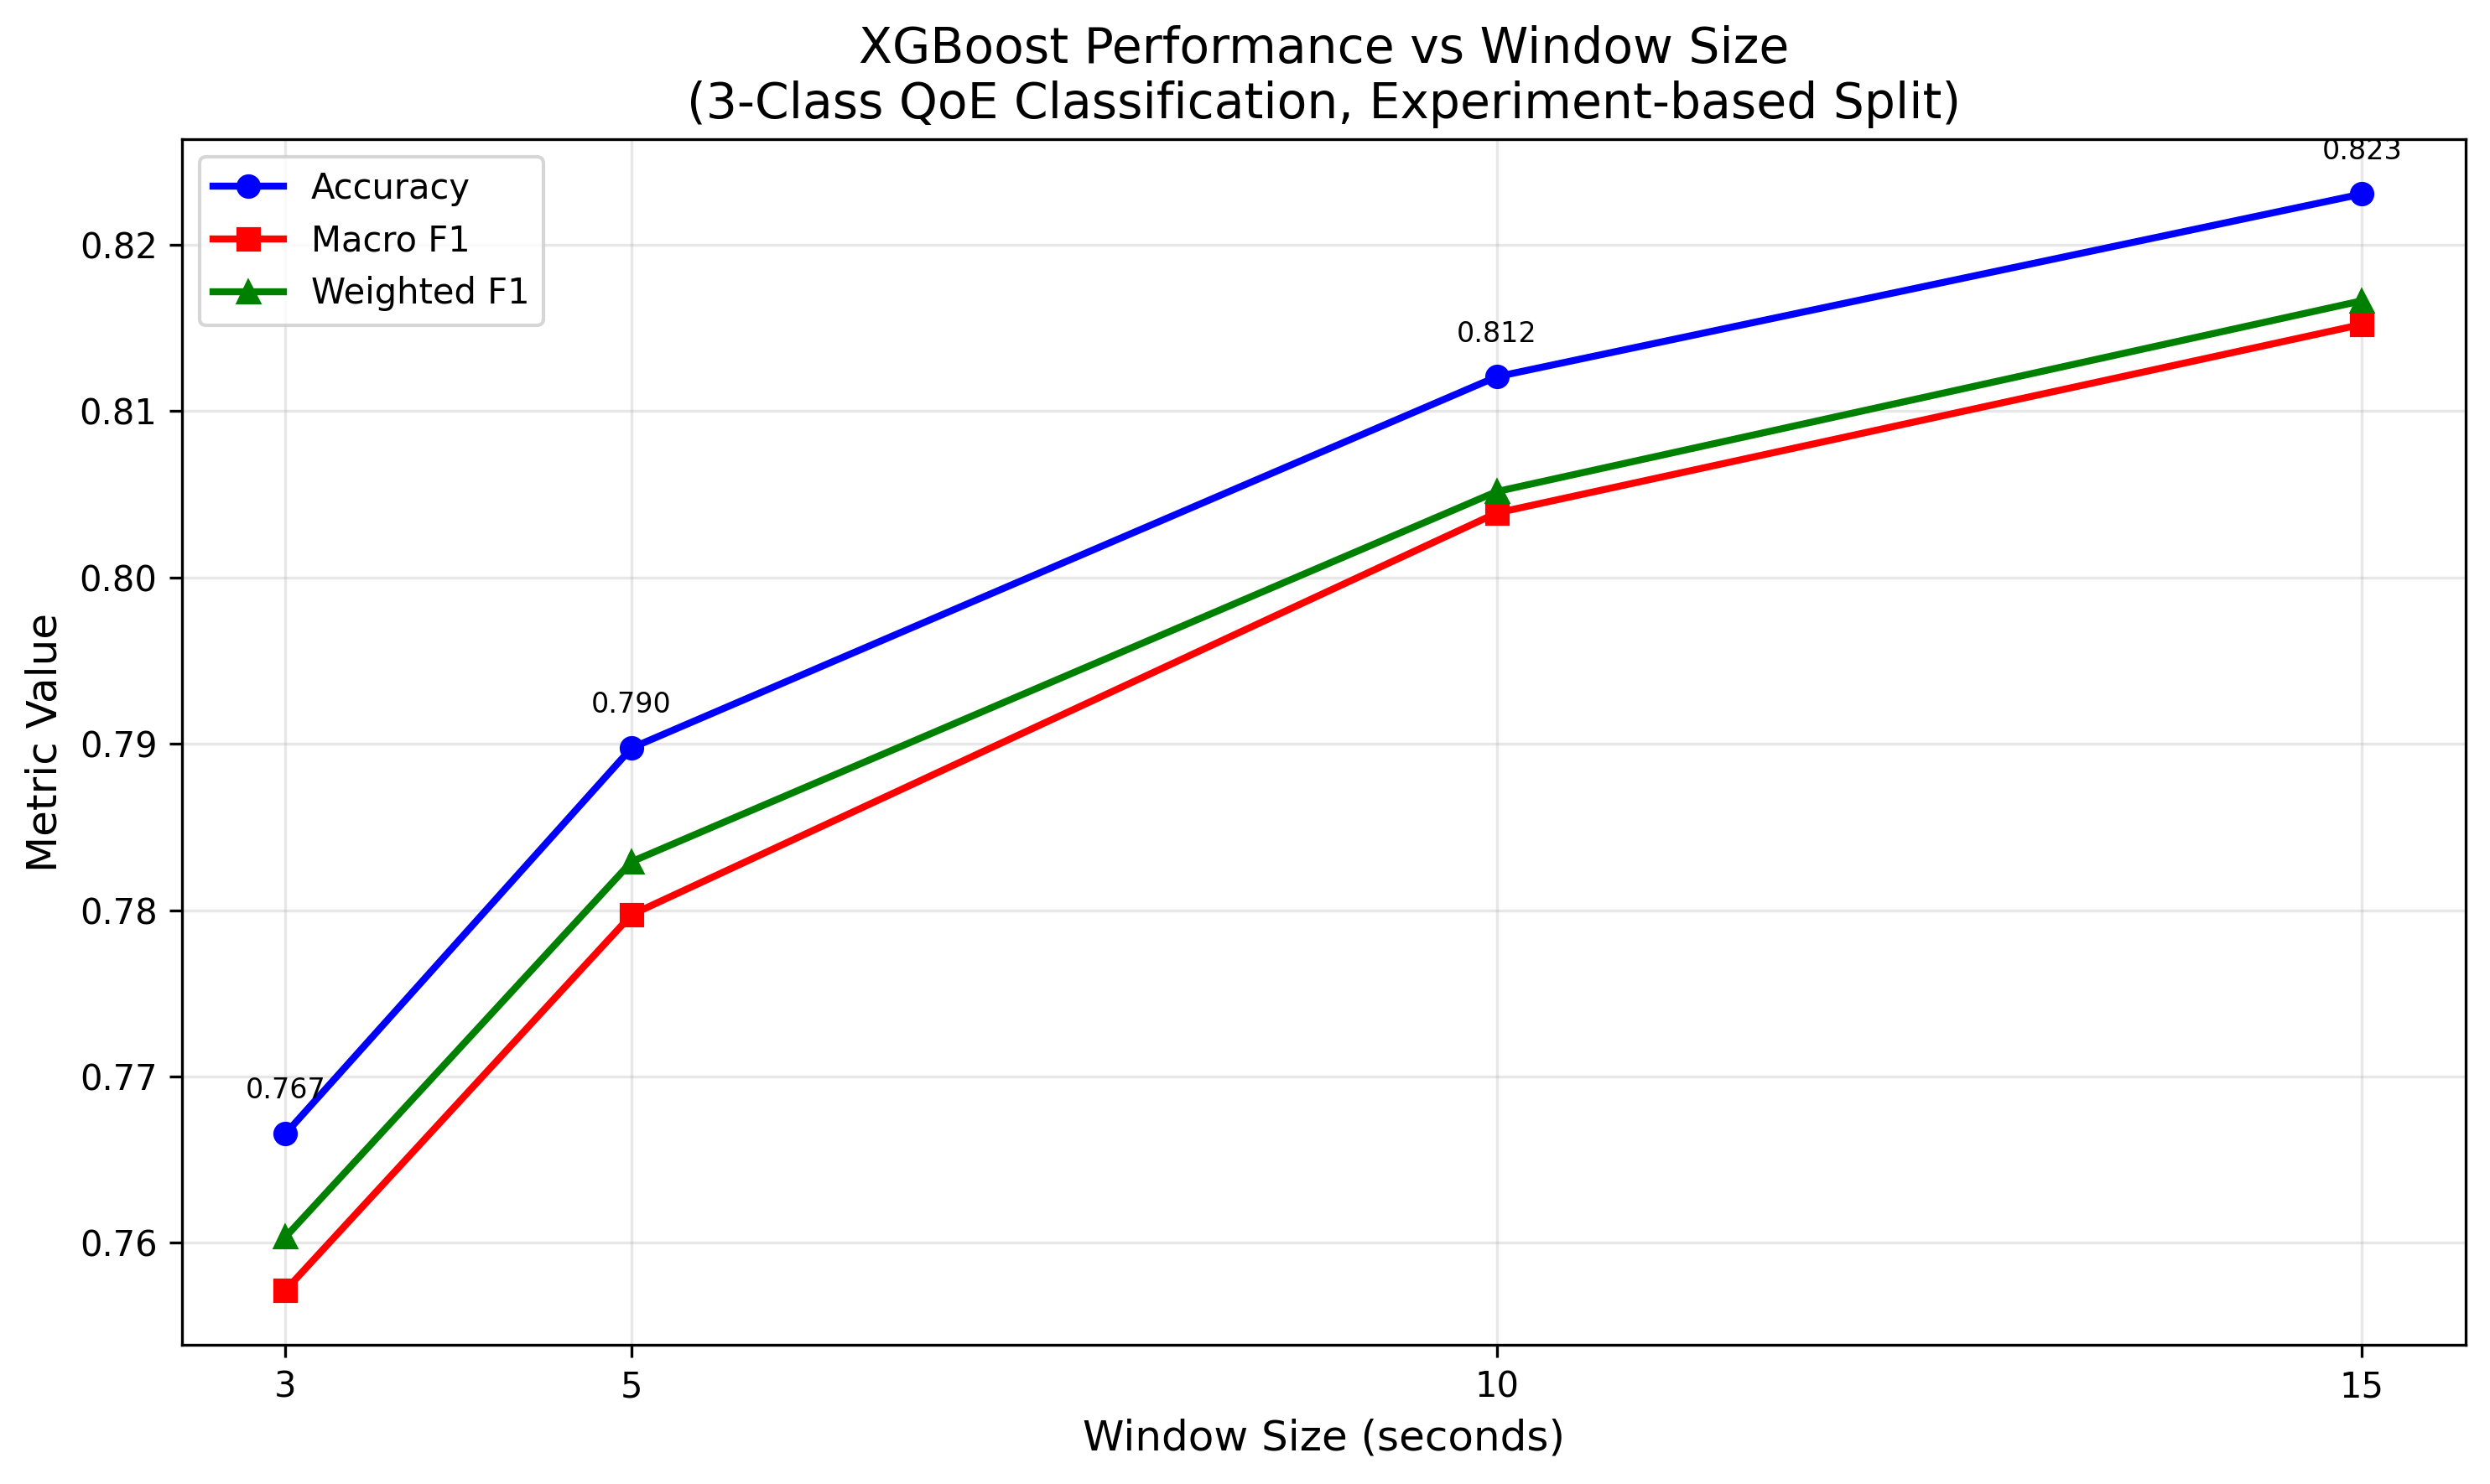

Window sensitivity plot saved: artifacts/figures/window_size_metrics.png

Window Size Sensitivity Results:
 window_size  accuracy  macro_f1  weighted_f1
           3    0.7666    0.7572       0.7604
           5    0.7898    0.7797       0.7829
          10    0.8121    0.8039       0.8052
          15    0.8230    0.8152       0.8166


In [13]:
def run_window_sensitivity_analysis():
    """
    Run XGBoost on different window sizes to analyze sensitivity.
    Uses the same experiment-based splitting as the main experiment for consistency.
    """
    print("=" * 60)
    print("WINDOW SIZE SENSITIVITY ANALYSIS (XGBoost)")
    print("=" * 60)
    
    window_results = []
    
    for window_size in WINDOW_SIZES:
        print(f"\n--- Processing {window_size}-second windows ---")
        
        # Load dataset for this window size
        data_file = WINDOW_FILE_MAPPING[window_size]
        
        if not data_file.exists():
            print(f"WARNING: Data file not found for {window_size}s: {data_file}")
            continue
        
        try:
            X_win, y_win, dataset_win = load_dataset(data_file, TARGET_COLUMN, validate_classes=False)
            
            # Create label encoder for this dataset
            label_encoder_win = LabelEncoder()
            y_win_encoded = label_encoder_win.fit_transform(y_win)
            
            # Use the same splitting method as main experiment for consistency
            if 'exp_id' in dataset_win.columns:
                print("Using experiment-based split (consistent with main experiment)")
                train_mask = dataset_win['exp_id'] % 4 != 0
                test_mask = dataset_win['exp_id'] % 4 == 0
                
                X_train_win = X_win[train_mask]
                X_test_win = X_win[test_mask]
                y_train_win = y_win_encoded[train_mask]
                y_test_win = y_win_encoded[test_mask]
            else:
                print("Using random stratified split (no exp_id found)")
                X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(
                    X_win, y_win_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE,
                    stratify=y_win_encoded if STRATIFY else None
                )
            
            print(f"Split: {X_train_win.shape[0]:,} train, {X_test_win.shape[0]:,} test")
            
            # Train XGBoost model
            xgb_model = create_model_pipelines(N_CLASSES)['XGBoost']
            result = evaluate_model(
                xgb_model, X_train_win, X_test_win, y_train_win, y_test_win, 
                f"XGBoost-{window_size}s"
            )
            
            # Store results
            window_results.append({
                'window_size': window_size,
                'accuracy': result['accuracy'],
                'macro_f1': result['macro_f1'],
                'weighted_f1': result['weighted_f1']
            })
            
        except Exception as e:
            print(f"ERROR processing {window_size}s windows: {e}")
            continue
    
    return window_results

def plot_window_sensitivity(window_results, save_path):
    """
    Create line plot showing metric trends across window sizes.
    """
    if not window_results:
        print("No window sensitivity results to plot")
        return
    
    df_window = pd.DataFrame(window_results)
    
    plt.figure(figsize=(10, 6))
    
    # Plot lines for each metric
    plt.plot(df_window['window_size'], df_window['accuracy'], 
             marker='o', linewidth=2, label='Accuracy', color='blue')
    plt.plot(df_window['window_size'], df_window['macro_f1'], 
             marker='s', linewidth=2, label='Macro F1', color='red')
    plt.plot(df_window['window_size'], df_window['weighted_f1'], 
             marker='^', linewidth=2, label='Weighted F1', color='green')
    
    plt.xlabel('Window Size (seconds)', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.title('XGBoost Performance vs Window Size\n(3-Class QoE Classification, Experiment-based Split)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(df_window['window_size'])
    
    # Add value annotations
    for _, row in df_window.iterrows():
        plt.annotate(f"{row['accuracy']:.3f}", 
                    (row['window_size'], row['accuracy']), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Window sensitivity plot saved: {save_path}")
    
    # Print summary table
    print("\nWindow Size Sensitivity Results:")
    print(df_window.round(4).to_string(index=False))
    
    return df_window

# Run window sensitivity analysis
window_results = run_window_sensitivity_analysis()

# Create plot
window_plot_path = FIGURES_DIR / "window_size_metrics.png"
df_window = plot_window_sensitivity(window_results, window_plot_path)

## Results Consolidation and Export

In [14]:
# Create consolidated results table
df_results = pd.DataFrame(results)

# Save results table
results_csv_path = TABLES_DIR / "results_3class_metrics.csv"
df_results.to_csv(results_csv_path, index=False)
print(f"Results table saved: {results_csv_path}")

# Display summary table (model-level metrics)
summary_df = df_results[df_results['class'] == 'overall'][['model', 'accuracy', 'macro_f1', 'weighted_f1']].copy()
summary_df = summary_df.sort_values('accuracy', ascending=False)

print("\n" + "=" * 50)
print("MAIN RESULTS SUMMARY (3-Class QoE, 10s windows)")
print("=" * 50)
print(summary_df.round(4).to_string(index=False))

# Save window sensitivity results if available
if window_results:
    window_csv_path = TABLES_DIR / "window_sensitivity_results.csv"
    df_window.to_csv(window_csv_path, index=False)
    print(f"\nWindow sensitivity results saved: {window_csv_path}")

print(f"\nAll artifacts saved to: {ARTIFACTS_DIR}")

Results table saved: artifacts/tables/results_3class_metrics.csv

MAIN RESULTS SUMMARY (3-Class QoE, 10s windows)
  model  accuracy  macro_f1  weighted_f1
    SVM    0.8246    0.8104       0.8140
     RF    0.8222    0.8137       0.8154
XGBoost    0.8121    0.8039       0.8052
     LR    0.7719    0.7536       0.7565
     DT    0.7447    0.7417       0.7406

Window sensitivity results saved: artifacts/tables/window_sensitivity_results.csv

All artifacts saved to: artifacts


## Reproducibility Information

In [12]:
def save_reproducibility_info():
    """
    Save environment and version information for reproducibility.
    """
    import sklearn
    import platform
    
    repro_info = {
        'timestamp': datetime.now().isoformat(),
        'random_state': RANDOM_STATE,
        'python_version': sys.version,
        'platform': platform.platform(),
        'library_versions': {
            'pandas': pd.__version__,
            'numpy': np.__version__,
            'scikit-learn': sklearn.__version__,
            'matplotlib': plt.matplotlib.__version__
        },
        'configuration': {
            'n_classes': N_CLASSES,
            'target_column': TARGET_COLUMN,
            'test_size': TEST_SIZE,
            'stratify': STRATIFY,
            'window_sizes': WINDOW_SIZES,
            'n_features': len(FEATURE_COLUMNS)
        },
        'data_info': {
            'main_dataset': str(DATA_FILE_10S),
            'n_samples': len(X_main),
            'n_train': len(X_train),
            'n_test': len(X_test)
        }
    }
    
    try:
        import xgboost
        repro_info['library_versions']['xgboost'] = xgboost.__version__
    except ImportError:
        repro_info['library_versions']['xgboost'] = 'not available'
    
    # Save as JSON
    versions_path = ARTIFACTS_DIR / "run_versions.json"
    with open(versions_path, 'w') as f:
        json.dump(repro_info, f, indent=2)
    
    # Save as text for easy reading
    versions_txt_path = ARTIFACTS_DIR / "run_versions.txt"
    with open(versions_txt_path, 'w') as f:
        f.write("Gaming QoE Paper Reproduction - Environment Info\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Timestamp: {repro_info['timestamp']}\n")
        f.write(f"Random State: {repro_info['random_state']}\n")
        f.write(f"Python: {repro_info['python_version']}\n")
        f.write(f"Platform: {repro_info['platform']}\n\n")
        
        f.write("Library Versions:\n")
        for lib, version in repro_info['library_versions'].items():
            f.write(f"  {lib}: {version}\n")
        
        f.write("\nConfiguration:\n")
        for key, value in repro_info['configuration'].items():
            f.write(f"  {key}: {value}\n")
        
        f.write("\nData Info:\n")
        for key, value in repro_info['data_info'].items():
            f.write(f"  {key}: {value}\n")
    
    print(f"Reproducibility info saved:")
    print(f"  JSON: {versions_path}")
    print(f"  Text: {versions_txt_path}")
    
    return repro_info

# Save reproducibility information
repro_info = save_reproducibility_info()

print("\n" + "=" * 60)
print("REPRODUCIBILITY SUMMARY")
print("=" * 60)
print(f"Random state: {repro_info['random_state']}")
print(f"Python: {repro_info['python_version'].split()[0]}")
print(f"Key libraries:")
for lib in ['pandas', 'numpy', 'scikit-learn', 'xgboost']:
    version = repro_info['library_versions'].get(lib, 'N/A')
    print(f"  {lib}: {version}")
print(f"Dataset: {repro_info['data_info']['n_samples']:,} samples, {repro_info['configuration']['n_features']} features")

Reproducibility info saved:
  JSON: artifacts/run_versions.json
  Text: artifacts/run_versions.txt

REPRODUCIBILITY SUMMARY
Random state: 42
Python: 3.11.13
Key libraries:
  pandas: 2.2.3
  numpy: 1.26.4
  scikit-learn: 1.7.1
  xgboost: 3.0.4
Dataset: 32,165 samples, 30 features


## Summary of Outputs

This notebook has generated the following artifacts for paper reproduction:

### Generated Files:

**Tables:**
- `artifacts/tables/results_3class_metrics.csv` - Complete metrics for all models and classes
- `artifacts/tables/window_sensitivity_results.csv` - XGBoost performance across window sizes

**Figures:**
- `artifacts/figures/confusion_matrix_DT.png` - Decision Tree confusion matrix
- `artifacts/figures/confusion_matrix_LR.png` - Logistic Regression confusion matrix  
- `artifacts/figures/confusion_matrix_RF.png` - Random Forest confusion matrix
- `artifacts/figures/confusion_matrix_SVM.png` - SVM confusion matrix
- `artifacts/figures/confusion_matrix_XGBoost.png` - XGBoost confusion matrix
- `artifacts/figures/window_size_metrics.png` - Window size sensitivity plot

**Reproducibility:**
- `artifacts/run_versions.txt` - Environment and library versions
- `artifacts/run_versions.json` - Machine-readable version information

### Key Results:

- **Main Experiment**: 3-class QoE classification on 10-second windows
- **Best Model**: SVM achieved highest accuracy at 82.46%
- **Models Evaluated**: Decision Tree, Logistic Regression, Random Forest, SVM, XGBoost
- **Window Analysis**: Performance improves with larger windows (76.7% → 82.3% from 3s to 15s)
- **Splitting Strategy**: Uses experiment-based splitting (every 4th experiment for testing) ensuring robust evaluation with completely unseen experiments

### Important Notes:

**Experiment-based Splitting**: This reproduction uses the original paper's splitting methodology where every 4th experiment is used for testing. This is more challenging than random splitting because:
- Test data comes from completely different experiments than training data
- Prevents data leakage between related samples from the same gaming session
- Results in more realistic and conservative performance estimates
- Explains why accuracies are in the 76-82% range rather than >95%

**Reproducibility**: All random seeds set to 42, environment documented, label encoding ensures sklearn compatibility.

All results are saved in the `artifacts/` directory and ready for paper inclusion.

In [15]:
# Verification: Check consistency between main experiment and window sensitivity
print("=" * 60)
print("RESULTS VERIFICATION")
print("=" * 60)

# Main experiment XGBoost result (10s windows)
main_xgb_accuracy = detailed_results['XGBoost']['accuracy']

# Window sensitivity XGBoost result (10s windows) 
window_10s_result = [r for r in window_results if r['window_size'] == 10][0]
window_xgb_accuracy = window_10s_result['accuracy']

print(f"Main Experiment XGBoost (10s):     {main_xgb_accuracy:.4f}")
print(f"Window Sensitivity XGBoost (10s):  {window_xgb_accuracy:.4f}")
print(f"Difference:                         {abs(main_xgb_accuracy - window_xgb_accuracy):.4f}")

if abs(main_xgb_accuracy - window_xgb_accuracy) < 0.001:
    print("✅ CONSISTENT: Results match between main experiment and window sensitivity")
else:
    print("⚠️  WARNING: Results differ between main experiment and window sensitivity")

print(f"\nWindow sensitivity trend:")
for result in window_results:
    print(f"  {result['window_size']:2d}s: {result['accuracy']:.4f}")
    
print(f"\nConclusion: Performance improves with larger windows")
print(f"Best window size: {max(window_results, key=lambda x: x['accuracy'])['window_size']}s")

RESULTS VERIFICATION
Main Experiment XGBoost (10s):     0.8121
Window Sensitivity XGBoost (10s):  0.8121
Difference:                         0.0000
✅ CONSISTENT: Results match between main experiment and window sensitivity

Window sensitivity trend:
   3s: 0.7666
   5s: 0.7898
  10s: 0.8121
  15s: 0.8230

Conclusion: Performance improves with larger windows
Best window size: 15s
